# MGO for Airy Problem

This notebook reproduces the results of Example B: **"EM Wave in unmagnetized plasma slab with linear density profile"** from [Donelly et al., 2021].

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib as mpl
from scipy.special import airy
import scipy

In [2]:
rcParams.update(mpl.rcParamsDefault)
rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.sans-serif": ["Computer Modern Roman"],
    "font.size": 16})
rcParams['axes.titlepad'] = 20

## O-mode on linear density profile
When $E$ is parallel to $B_0$ and propagation is perpendicular to $B_0$, we have:
$$
\left(\omega^2 - \omega_p^2 + c^2 \partial_x^2 \right) E(x) = 0
$$
or
$$
\left[ \partial_x^2 + \frac{\omega^2}{c^2} \left( 1 - \frac{n(x)}{n_c} \right) \right] E(x) = 0
$$

By using linear density profile $n(x) = n_c \left( 1 + \frac{c}{L_n} \right)$ and rescaling $q := (\omega^2 c^{-2} L_n^{-1})^{1/3} x$ we get Airy's Eq:
$$
\partial_q^2 E(q) - q E(q) = 0
$$
Assuming $E(x) \to 0$ for $x \to \infty$, the exact solution is the Airy function:
$$
E_{\text{ex}}(q) = \text{Ai}(q)
$$

### Ray Tracing

Weyl Symbol of dispersion operator is simply
$$
\mathcal{D}(z) = p^2 + q
$$

This gives the following ray tracing eq.

$$
\left(
\begin{array}{c}
\partial_\tau q \\
\partial_\tau p
\end{array}
\right)
=
\left(
\begin{array}{c}
2p \\
-1
\end{array}
\right)
$$
with exact solution
$$
\left(
\begin{array}{c}
q(\tau) \\
p(\tau)
\end{array}
\right)
=
\left(
\begin{array}{c}
- (p_0 - \tau)^2 \\
p_0 - \tau
\end{array}
\right)
$$
The solution is plotted below

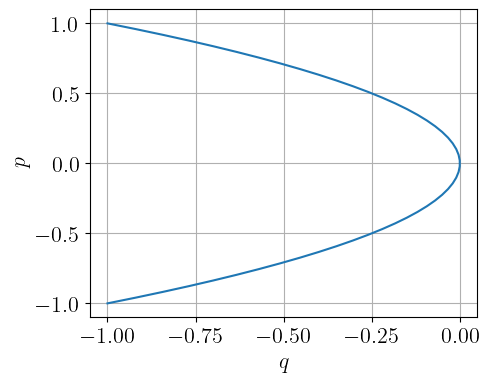

In [5]:
tau = np.linspace(0,2)
p_0 = 1
q = -(p_0 - tau)**2
p = p_0 - tau

plt.figure(figsize=(5,4))
plt.plot(q,p)
plt.xlabel(r'$q$')
plt.ylabel(r'$p$')
plt.grid()
plt.show()

### Metaplectic transformation

The canonical (symplectic transformation) which transforms $q$ to the tangent of the dispersion manifold is then:
$$
S_t = \frac{1}{\mathcal{v}(t)}
\left(
\begin{array}{cc}
2 p(t)  & -1    \\
1       & 2p(t) 
\end{array}
\right)
$$
The new ray phase space becomes
$$
\left(
\begin{array}{c}
Q_t (\tau) \\
P_t (\tau)
\end{array}
\right)
=  S_t
\left(
\begin{array}{c}
q(\tau) \\
p(\tau)
\end{array}
\right)
$$
Isolating and substituting $p(\tau)$ in $P_t(\tau)$ gives $P_t(Q)$.

The phase in transformed phase space is obtained from the group velocity and position as:
$$
\Theta_t(Q) = \int_{Q_t}^Q d Q' \, P_t(Q')
$$

And the dispersion relation in phase space is
$$
\mathcal{D}(S_t^{-1} Z(Q)) = 0
$$
From this, we can calculate the group velocity in phase space: $V_t = \partial_P \mathcal{D}$.

Envelope in phase space is obtained from
$$
V(Q) \, \partial_Q \Phi(Q)
+ \frac{1}{2} \left[ \partial_Q \cdot V(Q) \right] \Phi(Q) = 0
$$

*Lopez then performs a step, which I haven't studied in detail. This is the near-identity metaplectic transform part, which I think is to make the solution continuous.*

The wavefield at each branch is finally constructed by doing the inverse metaplectic transform:
$$
\psi(q) = \sum_{t} \psi_t(q)
$$

$$
\psi_t(q) = N_t(q) \Upsilon_t(q)
$$

$$
\Upsilon_t(q) =
\int d\epsilon \,\,
\Psi_t(\epsilon + Q_t(t))
\times
\exp(i \left( \Theta_t(\epsilon + Q_t) - \gamma_t(\epsilon) \right))
$$

$$
\gamma_t(\epsilon)
= G_1(q, Q) - G_1(q, Q_t)
=
\frac{1}{2} \epsilon^T D_t B_t^{-1} \epsilon 
+ \left[ D_t^T Q_t(t) - q \right]^T B_t^{-1} \epsilon
$$

In the 1D Airy Equation case this becomes
$$
E_{\text{MGO}} (q) =
\Upsilon(|q|^{1/2})
\exp(- i \frac{2}{3} |q|^{3/2} )
+
\Upsilon(-|q|^{1/2})
\exp(i \frac{2}{3} |q|^{3/2} )
$$

## Approximate Solutions

First, we plot the approximate solutions together with the exact Airy function.

In [3]:
def Ai(x):
    ai, *_ = airy(x)
    return ai

def Bi(x):
    _, _, bi, _ = airy(x)
    return bi

q = np.linspace(-8, 0, 1000)
E_ex = Ai(q) # Exact solution is Airy function
GO = lambda q:  np.pi**(-1/2) * (np.abs(q)**(-1/4)) * np.sin(2/3 * np.abs(q)**(3/2) + np.pi/4) # GO Solution
E_GO = np.piecewise(q, [q == 0, q != 0],  [lambda q: np.nan, GO])

In [4]:
rho = (1-4*q) * np.sqrt(np.abs(q))
omega_bar = 2/3 * rho**3 - 2/3 * np.abs(q)**(3/2)
E_approx_MGO = np.sqrt(1-4*q) * (Ai(-rho**2) * np.cos(omega_bar) - Bi(-rho**2) * np.sin(omega_bar))

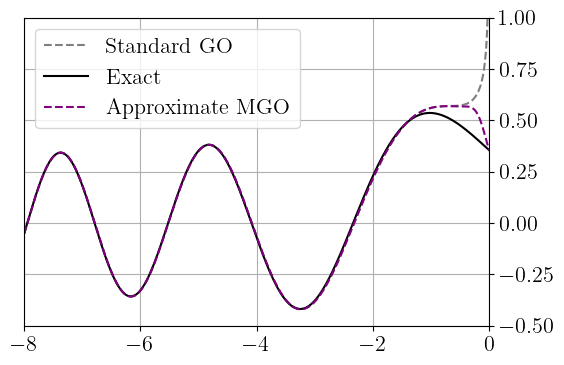

In [5]:
plt.figure(figsize=(6,4))
plt.plot(q, E_GO, '--', color='tab:grey', label='Standard GO')
plt.plot(q, E_ex, '-', color='black', label='Exact')
plt.plot(q, E_approx_MGO, '--', color='purple', label='Approximate MGO')
plt.grid()
plt.xlim(-8,0)
plt.ylim(-0.5,1)
plt.legend()
ax = plt.gca()
ax.yaxis.set_label_position('right')
ax.yaxis.tick_right()
plt.show()

## Numerical Evaluation

We now perform the numerical evaluation of the MGO solution using Gaussian quadratures to evaluate the integral.

In [6]:
def get_nodes_and_weights(n):
    '''Returns nodes and weights from Freud polynomials for evaluating gaussian quadrature.'''
    nodes = [
        [5.64189583547756e-1],
        [3.00193931060839e-1, 1.25242104533372e-0],
        [1.90554149798192e-1, 8.48251867544577e-1, 1.79977657841573e-0],
        [1.33776446996068e-1, 6.24324690187190e-1, 1.34253782564499e-0, 2.26266447701036e-0],
        [1.00242151968216e-1, 4.82813966046201e-1, 1.06094982152572e-0, 1.77972941852026e-0, 2.66976035608766e-0],
        [7.86006594130979e-2, 3.86739410270631e-1, 8.66429471682044e-1, 1.46569804966352e-0, 2.17270779693900e-0, 3.03682016932287e-0],
        [6.37164846067008e-2, 3.18192018888619e-1, 7.24198989258373e-1, 1.23803559921509e-0, 1.83852822027095e-0, 2.53148815132768e-0, 3.37345643012458e-0],
        [5.29786439318514e-2, 2.67398372167767e-1, 6.16302884182402e-1, 1.06424631211623e-0, 1.58885586227006e-0, 2.18392115309586e-0, 2.86313388370808e-0, 3.68600716272440e-0],
        [4.49390308011934e-2, 2.28605305560535e-1, 5.32195844331646e-1, 9.27280745338081e-1, 1.39292385519588e-0, 1.91884309919743e-0, 2.50624783400574e-0, 3.17269213348124e-0, 3.97889886978978e-0],
        [3.87385243257289e-2, 1.98233304013083e-1, 4.65201111814767e-1, 8.16861885592273e-1, 1.23454132402818e-0, 1.70679814968913e-0, 2.22994008892494e-0, 2.80910374689875e-0, 3.46387241949586e-0, 4.25536180636608e-0]
    ]
    weights = [
        [8.86226925452758e-1],
        [6.40529179684379e-1, 2.45697745768379e-1],
        [4.46029770466658e-1, 3.96468266998335e-1, 4.37288879877644e-2],
        [3.25302999756919e-1, 4.21107101852062e-1, 1.33442500357520e-1, 6.37432348625728e-3],
        [2.48406152028443e-1, 3.92331066652399e-1, 2.11418193076057e-1, 3.32466603513439e-2, 8.24853344515628e-4],
        [1.96849675488598e-1, 3.49154201525395e-1, 2.57259520584421e-1, 7.60131375840058e-2, 6.85191862513596e-3, 9.84716452019267e-5],
        [1.60609965149261e-1, 3.06319808158099e-1, 2.75527141784905e-1, 1.20630193130784e-1, 2.18922863438067e-2, 1.23644672831056e-3, 1.10841575911059e-5],
        [1.34109188453360e-1, 2.68330754472640e-1, 2.75953397988422e-1, 1.57448282618790e-1, 4.48141099174625e-2, 5.36793575602526e-3, 2.02063649132407e-4, 1.19259692659532e-6],
        [1.14088970242118e-1, 2.35940791223685e-1, 2.66425473630253e-1, 1.83251679101663e-1, 7.13440493066916e-2, 1.39814184155604e-2, 1.16385272078519e-3, 3.05670214897831e-5, 1.23790511337496e-7],
        [9.85520975191087e-2, 2.08678066608185e-1, 2.52051688403761e-1, 1.98684340038387e-1, 9.71984227600620e-2, 2.70244164355446e-2, 3.80464962249537e-3, 2.28886243044656e-4, 4.34534479844469e-6, 1.24773714817825e-8]
    ]
    return np.array(nodes[n-1]), np.array(weights[n-1])

In [7]:
def integrate_gauss_freud_quad(f, n):
    '''Integrate f(x) from 0 to ∞ using Gauss Freud Quadrature of order n'''
    x_j, w_j = get_nodes_and_weights(n)
    return np.dot(w_j,  np.exp(x_j**2)*f(x_j))

In [8]:
# Define function to be integrated.
v = lambda p: np.sqrt(1+4*(p**2))
f = lambda eps, p: (
    (v(p)**6 - (v(p)**4 - 8*v(p)*p*eps)**(3/2))/(96*(p**3))
    - v(p)**3/(8*(p**2)) * eps + v(p)**2/(4*p) * eps**2
    )
df = lambda eps, p: v(p)/(8*(p**2)) * (
    4*v(p)*p*eps
    - v(p)**2
    + (v(p)**4 - 8*v(p)*p*eps)**(1/2)
    )
ddf = lambda eps, p: v(p)**2/(2*p) * (1 - (v(p)**4 - 8*v(p)*p*eps)**(-1/2)) 
g = lambda eps, p: (1/(2*np.pi)) * v(p)/(v(p)**4 - 8*v(p)*p*eps)**(1/4)

In [9]:
# sample check that values are correct
# f(4,2), g(4,2), df(4,2), ddf(4,2), g(4,2)

In [10]:
def Upsilon(p_vec):
    def integral(p, sigma_p, sigma_m, s_p, s_m):
        h = lambda eps: g(eps, p) * np.exp(1j*f(eps, p))
        dl_p, dl_m = np.exp(1j*sigma_p)/np.sqrt(s_p), np.exp(1j*sigma_m)/np.sqrt(s_m)
        I = integrate_gauss_freud_quad(
            lambda l: (h(eps_0 + l*dl_p) * dl_p - h(eps_0 + l*dl_m) * dl_m),
            n = 10
        )
        return I

    def start_angles(p):
        alpha = np.angle(ddf(eps_0, p))
        sigma_p = -np.pi/4 - alpha/2 + np.pi/2
        sigma_m = -np.pi/4 - alpha/2 - np.pi/2
        return sigma_p, sigma_m

    def get_l_and_s(p, sigma_p, sigma_m):
        Delta_F = 1

        C_p = lambda l: eps_0 + np.abs(l) * np.exp(1j*sigma_p)
        C_m = lambda l: eps_0 + np.abs(l) * np.exp(1j*sigma_m)

        F_p = lambda l: np.imag(f(C_p(l), p))
        F_m = lambda l: np.imag(f(C_m(l), p))

        l_p = scipy.optimize.brentq(lambda l: F_p(l) - F_p(0) - Delta_F, 0, 1000)
        l_m = scipy.optimize.brentq(lambda l: F_m(l) - F_m(0) - Delta_F, 0, 1000)

        s_p = Delta_F/(np.abs(l_p)**2)
        s_m = Delta_F/(np.abs(l_m)**2)

        return l_p, l_m, s_p, s_m
    
    eps_0 = 0
    p = p_vec[0]
    sigma_p, sigma_m = start_angles(p)
    l_p, l_m, s_p, s_m = get_l_and_s(p, sigma_p, sigma_m)

    I = np.zeros_like(p_vec, dtype=np.complex_)
    for i, p in enumerate(p_vec):
        if np.isclose(p, 0, atol=1e-4):
            I[i] = I[i-1]
            continue

        def new_angle(sigma, r, Delta_sigma):
            '''Calculate new direction of steepest descent
                in Delta_sigma neighbourhood of old direction, sigma.'''
            C_circ = lambda _r, theta: _r*np.exp(1j*theta)
            F_circ = lambda theta: np.imag(f(C_circ(r, theta), p))
            sigmas = np.linspace(sigma - Delta_sigma/2, sigma + Delta_sigma/2)
            new_angle = sigmas[np.argmax(F_circ(sigmas))]
            return new_angle

        Delta_sigma = 0.01
        sigma_p, sigma_m = new_angle(sigma_p, l_p, Delta_sigma), new_angle(sigma_m, l_m, Delta_sigma)
        I[i] = integral(p, sigma_p, sigma_m, s_p, s_m)
    
    return I

# q = np.linspace(-8, -10**(-3), 90)
E_MGO = ( Upsilon(np.sqrt(np.abs(q))) * np.exp(-1j*(2/3)*(np.abs(q)**(3/2)))
         + Upsilon(-np.sqrt(np.abs(q))) * np.exp(1j*(2/3)*(np.abs(q)**(3/2))) )
if np.all(np.isclose(np.imag(E_MGO), 0)):
    E_MGO = np.real(E_MGO)
else:
    print('Warning: Field has non-negligible imaginary part even though we discard the imagine part.')

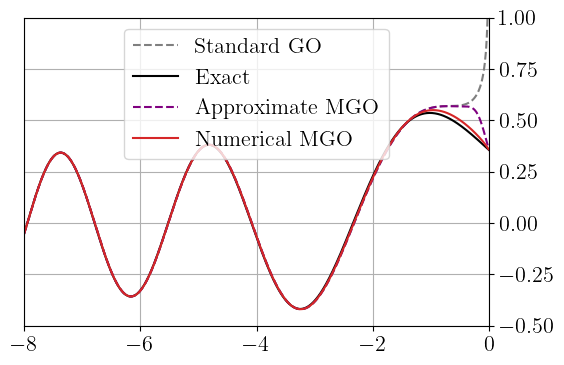

In [11]:
plt.figure(figsize=(6,4))
plt.plot(q, E_GO, '--', color='tab:grey', label='Standard GO')
plt.plot(q, E_ex, '-', color='black', label='Exact')
plt.plot(q, E_approx_MGO, '--', color='purple', label='Approximate MGO')
plt.plot(q, E_MGO, '-', color='tab:red', label='Numerical MGO')
plt.grid()
plt.xlim(-8,0)
plt.ylim(-0.5,1)
plt.legend()
ax = plt.gca()
ax.yaxis.set_label_position('right')
ax.yaxis.tick_right()
plt.show()

### Reproduced FIG. 4

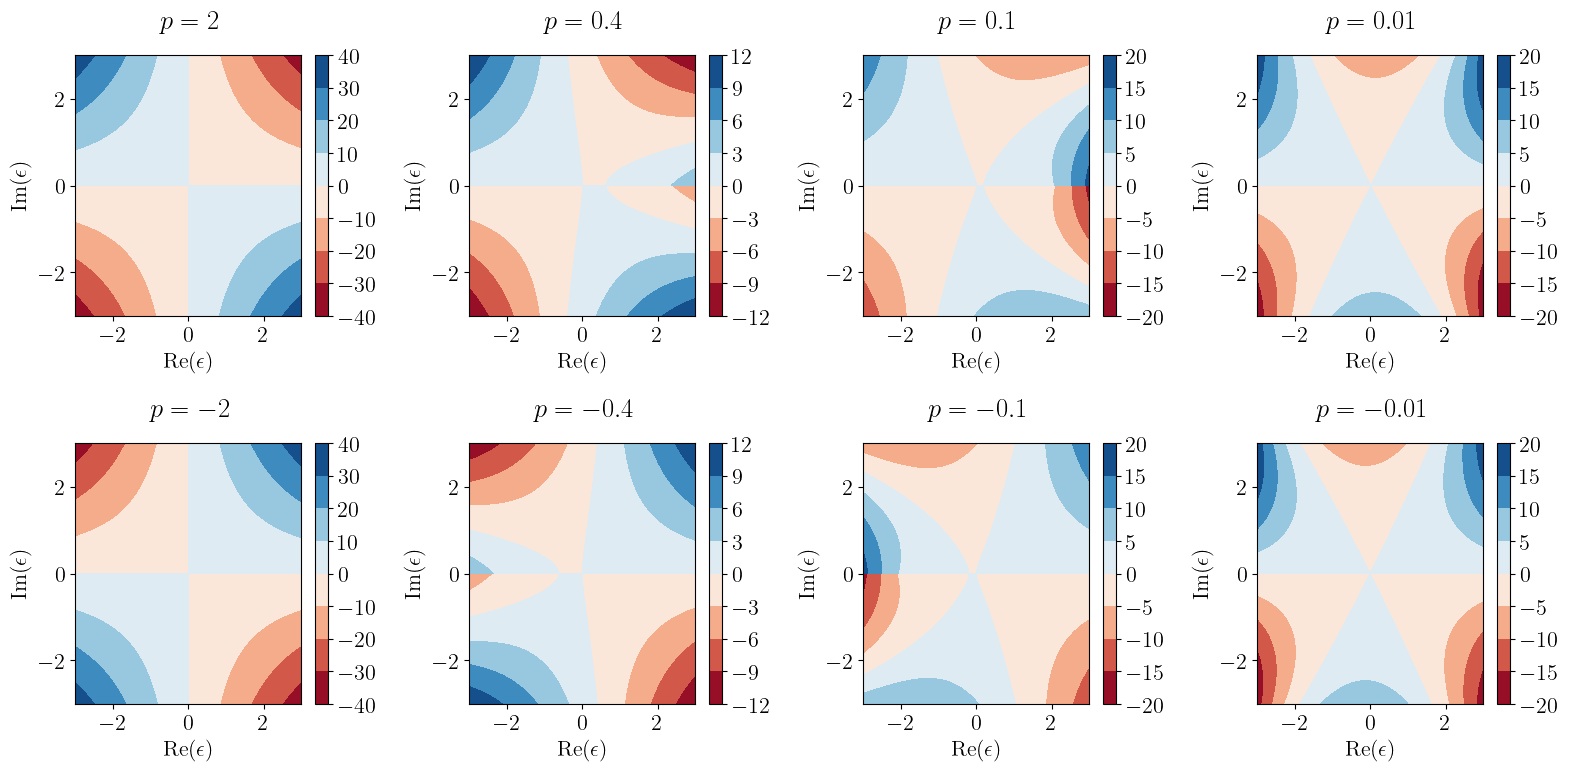

In [12]:
eps_R = np.linspace(-3,3, 1000)
eps_I = np.linspace(-3,3, 1000)
Eps_R, Eps_I = np.meshgrid(eps_R, eps_I)
Eps = Eps_R + 1j*Eps_I

p_vals = [2, 0.4, 0.1, 0.01, -2, -0.4, -0.1, -0.01]
# p_vals = [0.01, 0.05, 0.1, 0.5, 0.8, 1.0, 1.5, 2.0]
nrows, ncols = int(np.ceil(len(p_vals)/4)), 4
# fig, axes = plt.subplots(nrows, ncols, figsize=(14,8))
fig = plt.figure(figsize=(16,nrows*4))

for i, p in enumerate(p_vals):
    # Plot $- Im{ f(eps,p) }$ (imaginary part of phase function)
    ax = fig.add_subplot(nrows, ncols, 1 + i)
    contour_plot = ax.contourf(Eps_R, Eps_I, -np.imag(f(Eps, p)), cmap='RdBu')
    fig.colorbar(contour_plot, ax=ax)
    ax.set_title('$p = ' + str(p) + '$')
    ax.set_xlabel(r'$\mathrm{Re}(\epsilon)$')
    ax.set_ylabel(r'$\mathrm{Im}(\epsilon)$')
plt.tight_layout()
plt.show()

In [13]:
# fig = plt.figure(figsize=(13,6))

# for i, p in enumerate(p_vals):
#     # Plot $- Im{ f(eps,p) }$ (imaginary part of phase function)
#     ax = fig.add_subplot(nrows, ncols, 1 + i)
#     contour_plot = ax.contourf(Eps_R, Eps_I, np.real(df(Eps, p)))
#     fig.colorbar(contour_plot, ax=ax)
#     ax.set_title('$p = ' + str(p) + '$')
#     ax.set_xlabel(r'$\mathrm{Re}(\epsilon)$')
#     ax.set_ylabel(r'$\mathrm{Im}(\epsilon)$')
# plt.tight_layout()

# fig = plt.figure(figsize=(13,6))

# for i, p in enumerate(p_vals):
#     # Plot $- Im{ f(eps,p) }$ (imaginary part of phase function)
#     ax = fig.add_subplot(nrows, ncols, 1 + i)
#     contour_plot = ax.contourf(Eps_R, Eps_I, np.imag(df(Eps, p)))
#     fig.colorbar(contour_plot, ax=ax)
#     ax.set_title('$p = ' + str(p) + '$')
#     ax.set_xlabel(r'$\mathrm{Re}(\epsilon)$')
#     ax.set_ylabel(r'$\mathrm{Im}(\epsilon)$')
# plt.tight_layout()